<a href="https://colab.research.google.com/github/TomODonn/ECGR-4105/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import ipywidgets as widgets
from IPython.display import display

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data.csv') # Replace with the path to your CSV file
data.describe()

,Released_Year,runtime,rating,lead_actor_rank,release_month
count,341.000000,341.000000,341.000000,341.000000,341.000000
mean,2002.046921,131.439883,7.939003,393.923754,8.568915
std,12.940730,27.081577,0.310650,540.561359,3.163036
min,1956.000000,81.000000,7.600000,1.000000,1.000000
25%,1995.000000,113.000000,7.700000,56.000000,6.000000
50%,2005.000000,127.000000,7.900000,148.000000,10.000000
75%,2012.000000,143.000000,8.100000,568.000000,11.000000
max,2020.000000,242.000000,9.300000,2840.000000,12.000000


In [2]:
# Find rows with data issues
data.isna().sum()

,0
title,0
Released_Year,0
runtime,0
genre,0
rating,0
gross,6
director,0
lead_actor,0
lead_actor_rank,0
lead_actor_total_revenue,0


In [3]:
# Remove those rows
data = data.dropna()
data.describe(include = 'all')

,title,Released_Year,runtime,genre,rating,gross,director,lead_actor,lead_actor_rank,lead_actor_total_revenue,lead_actor_avg_revenue,budget,release_date,release_month,release_season
count,335,335.000000,335.000000,335,335.000000,335,335,335,335.000000,335,335,335,335,335.000000,335
unique,335,NaN,NaN,10,NaN,335,198,206,NaN,206,206,118,321,NaN,4
top,The Shawshank Redemption,NaN,NaN,Drama,NaN,"28,341,469.00",Steven Spielberg,Tom Hanks,NaN,"10,857,762,422.00","193,888,615.00","15,000,000.00",9/20/2012,NaN,Fall
freq,1,NaN,NaN,84,NaN,1,11,12,NaN,12,12,17,2,NaN,126
mean,NaN,2001.985075,131.391045,NaN,7.940299,NaN,NaN,NaN,393.985075,NaN,NaN,NaN,NaN,8.525373,NaN
std,NaN,12.773818,27.130742,NaN,0.312350,NaN,NaN,NaN,541.434375,NaN,NaN,NaN,NaN,3.171512,NaN
min,NaN,1956.000000,81.000000,NaN,7.600000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,1.000000,NaN
25%,NaN,1995.000000,113.000000,NaN,7.700000,NaN,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,6.000000,NaN
50%,NaN,2005.000000,127.000000,NaN,7.900000,NaN,NaN,NaN,148.000000,NaN,NaN,NaN,NaN,9.000000,NaN
75%,NaN,2012.000000,143.500000,NaN,8.100000,NaN,NaN,NaN,568.000000,NaN,NaN,NaN,NaN,11.000000,NaN


In [4]:
# Convert columns to numeric, removing commas and converting to float
if not pd.api.types.is_numeric_dtype(data['runtime']):
  data['runtime'] = data['runtime'].str.replace(',', '').astype(float)

if not pd.api.types.is_numeric_dtype(data['budget']):
  data['budget'] = data['budget'].str.replace(',', '').astype(float)

if not pd.api.types.is_numeric_dtype(data['lead_actor_total_revenue']):
  data['lead_actor_total_revenue'] = data['lead_actor_total_revenue'].str.replace(',', '').astype(float)

if not pd.api.types.is_numeric_dtype(data['lead_actor_avg_revenue']):
  data['lead_actor_avg_revenue'] = data['lead_actor_avg_revenue'].str.replace(',', '').astype(float)

if not pd.api.types.is_numeric_dtype(data['gross']):
  data['gross'] = data['gross'].str.replace(',', '').astype(float)

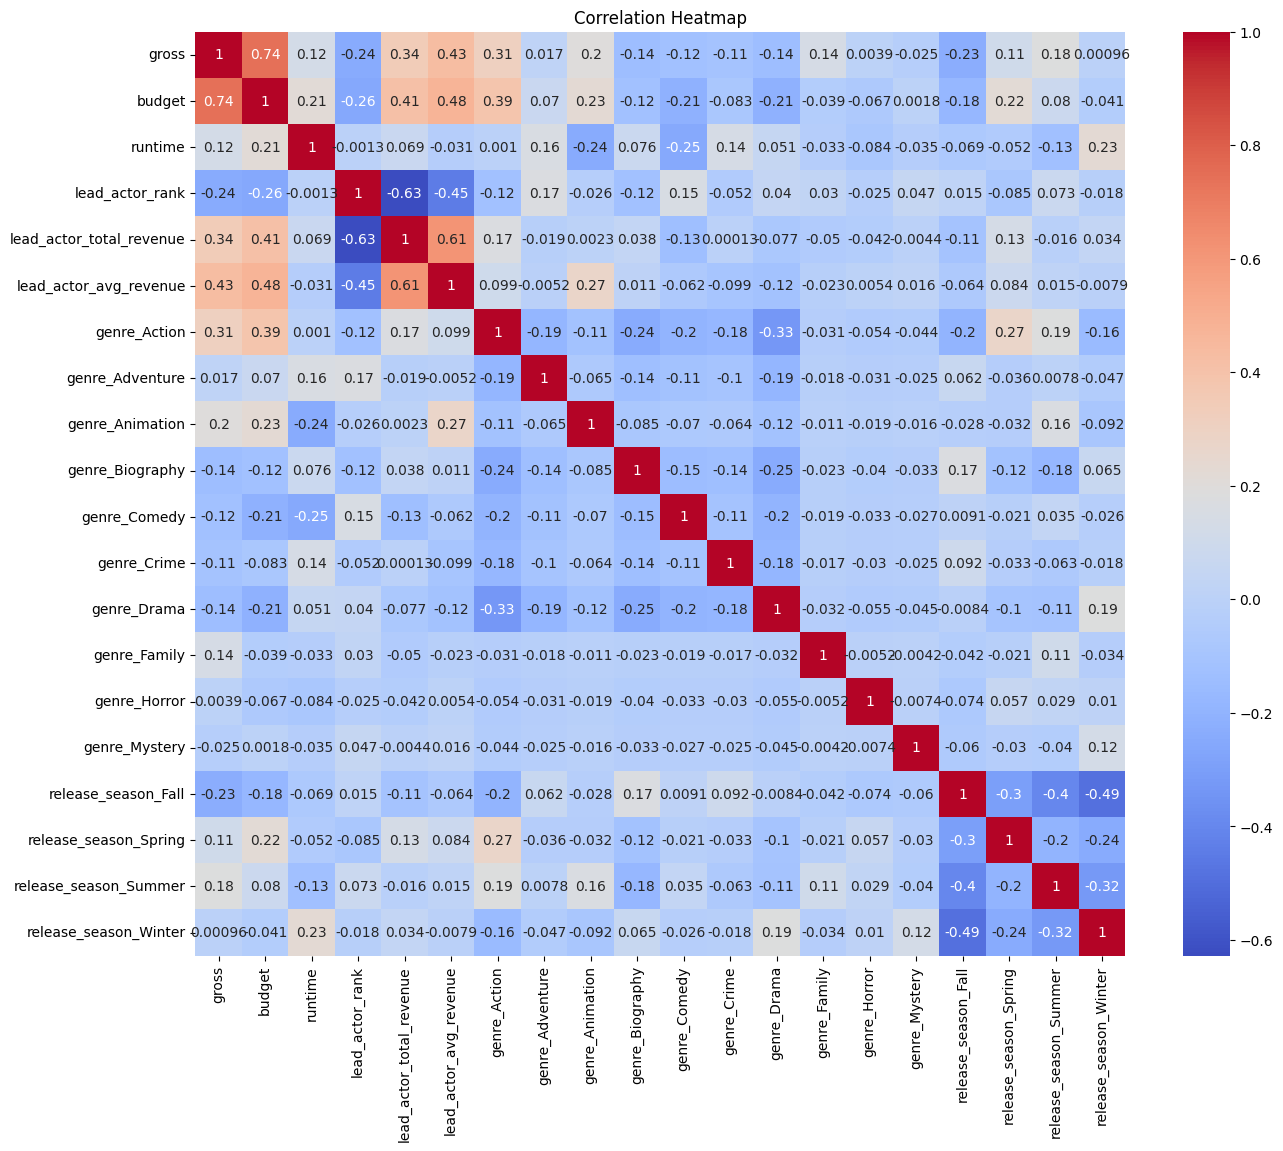

In [5]:
# Apply one-hot encoding to categorical features
data_encoded = pd.get_dummies(data, columns=['genre', 'release_season'])

# Select relevant features, including one-hot encoded columns
corr_features_encoded = ['gross', 'budget', 'runtime', 'lead_actor_rank',
                         'lead_actor_total_revenue', 'lead_actor_avg_revenue'] + \
                        [col for col in data_encoded.columns if col.startswith('genre_') or col.startswith('release_season_')]

# Calculate the correlation matrix
corr_encoded = data_encoded[corr_features_encoded].corr()

# Plot the heatmap
plt.figure(figsize=(15, 12))  # Adjust figure size as needed
sns.heatmap(corr_encoded, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [6]:
X = data[['budget', 'runtime', 'genre', 'release_season', 'director', 'lead_actor_rank', 'lead_actor_total_revenue', 'lead_actor_avg_revenue']]
y_rating = data['rating']
y_box_office = data['gross']

numeric_features = ['budget', 'runtime', 'lead_actor_rank', 'lead_actor_total_revenue', 'lead_actor_avg_revenue']
categorical_features = ['genre', 'release_season', 'director']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

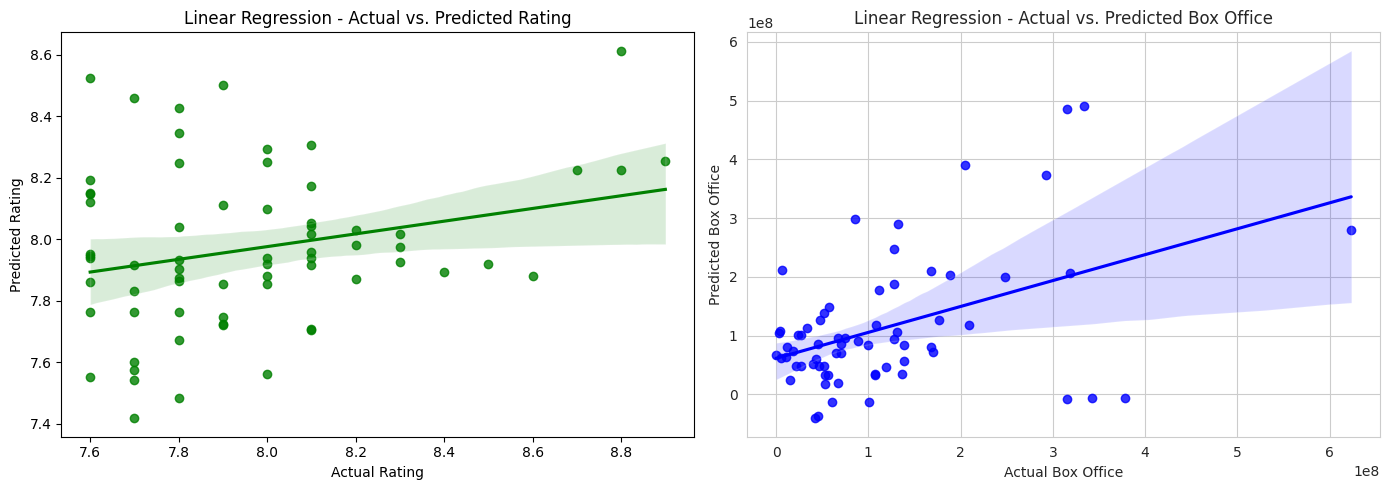

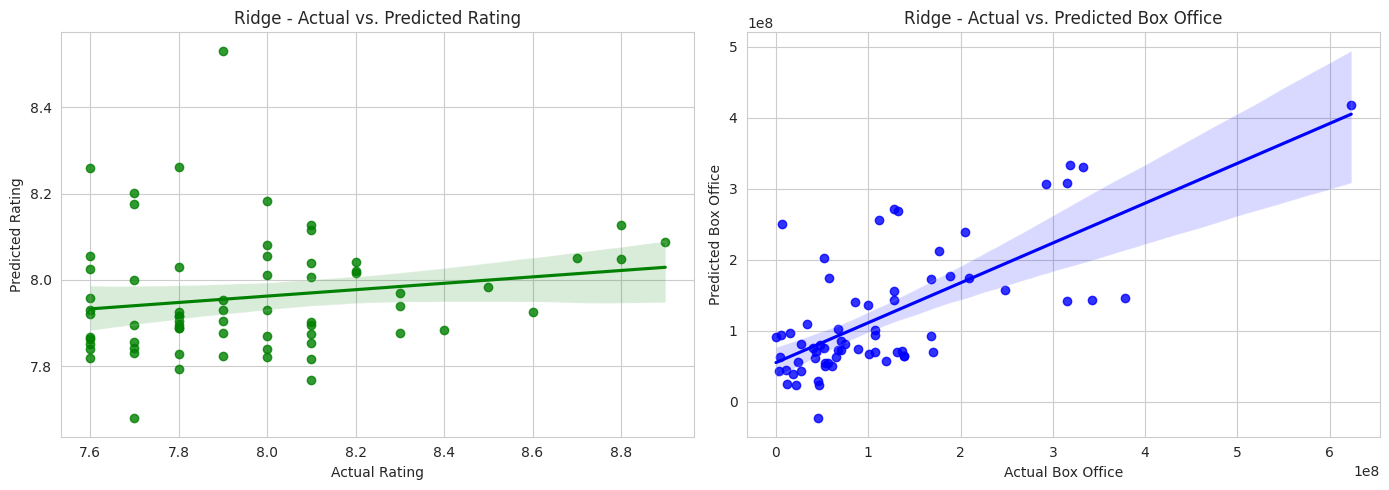

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9304274178528557e+17, tolerance: 440839887289882.3
  model = cd_fast.sparse_enet_coordinate_descent(


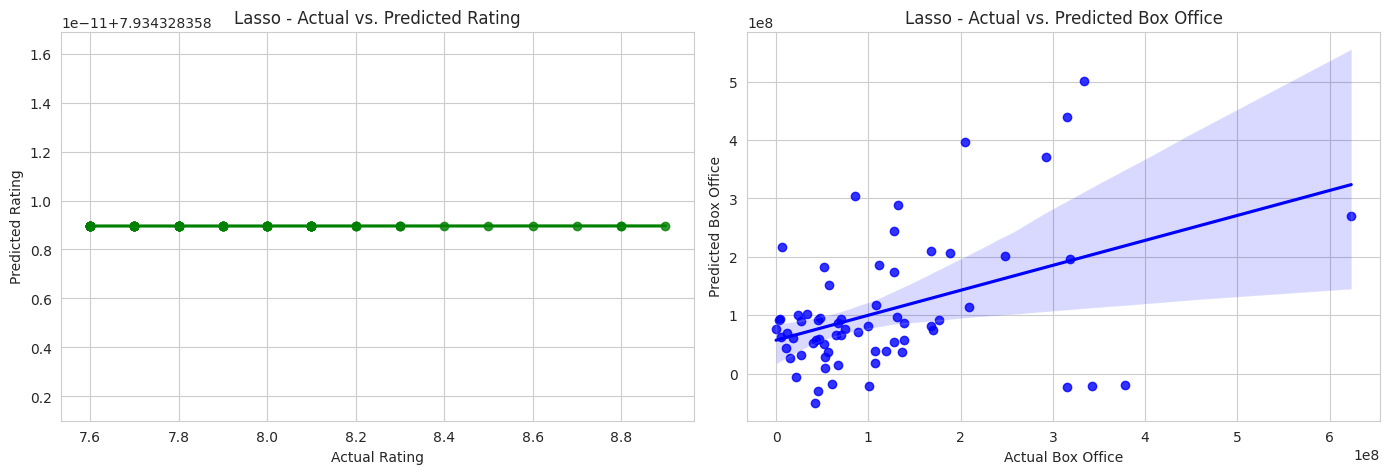

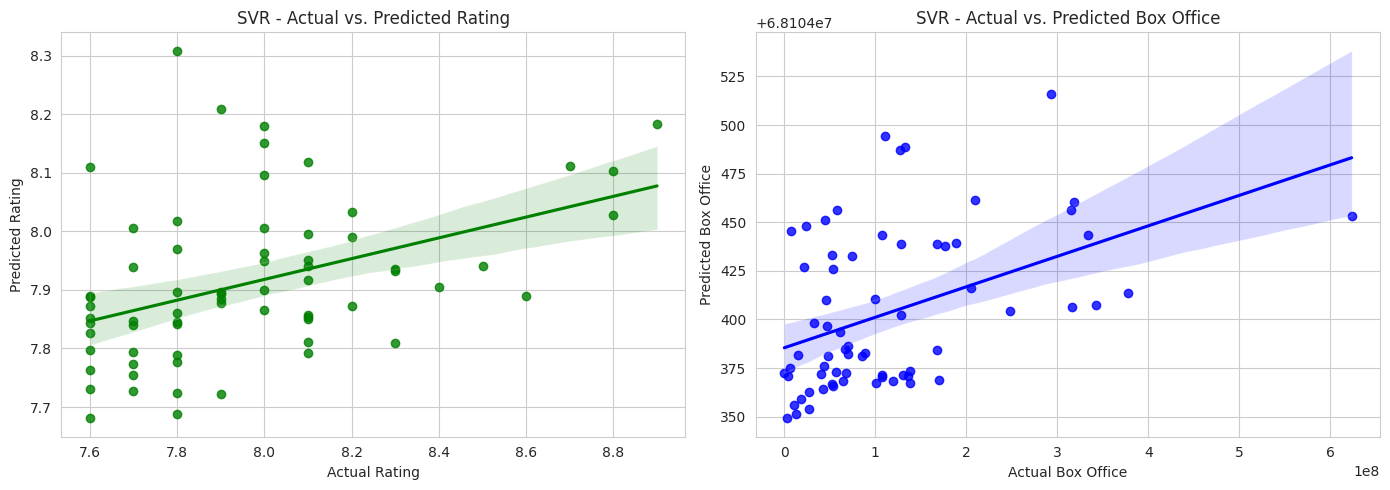

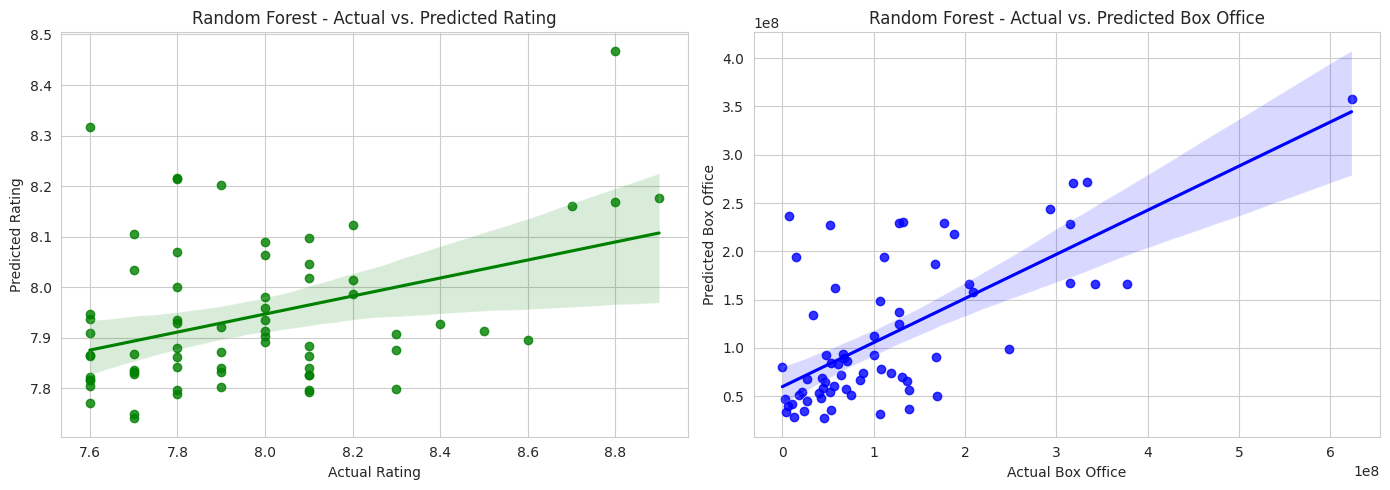

Linear Regression - Rating RMSE: 0.3539388520051606, Box Office RMSE: 117478472.80181137
Ridge - Rating RMSE: 0.3234265353363529, Box Office RMSE: 80234810.67694302
Lasso - Rating RMSE: 0.31843205754585924, Box Office RMSE: 120508605.03184427
SVR - Rating RMSE: 0.29200073495624285, Box Office RMSE: 122404101.36040421
Random Forest - Rating RMSE: 0.29412379330529825, Box Office RMSE: 82787551.1474013


In [7]:
# Define the models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(max_iter=10000),
    'SVR': SVR(),
    'Random Forest': RandomForestRegressor()
}

# Define hyperparameters for tuning
param_grid = {
    'Linear Regression': {},
    'Ridge': {'regressor__alpha': [0.1, 1.0, 10.0]},
    'Lasso': {'regressor__alpha': [0.1, 1.0, 10.0]},
    'SVR': {'regressor__C': [0.1, 1.0, 10.0], 'regressor__epsilon': [0.01, 0.1, 1.0]},
    'Random Forest': {'regressor__n_estimators': [100, 200], 'regressor__max_depth': [None, 10, 20]}
}

results = {}

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    search = GridSearchCV(pipeline, param_grid[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

    X_train, X_test, y_rating_train, y_rating_test, y_box_office_train, y_box_office_test = train_test_split(
        X, y_rating, y_box_office, test_size=0.2, random_state=42)

    search.fit(X_train, y_rating_train)
    y_rating_pred = search.predict(X_test)
    rating_rmse = np.sqrt(mean_squared_error(y_rating_test, y_rating_pred))

    search.fit(X_train, y_box_office_train)
    y_box_office_pred = search.predict(X_test)
    box_office_rmse = np.sqrt(mean_squared_error(y_box_office_test, y_box_office_pred))

    results[name] = (rating_rmse, box_office_rmse)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    sns.regplot(x=y_rating_test, y=y_rating_pred, color='g')
    sns.set_style("whitegrid")
    plt.xlabel('Actual Rating')
    plt.ylabel('Predicted Rating')
    plt.title(f'{name} - Actual vs. Predicted Rating')

    plt.subplot(1, 2, 2)
    sns.regplot(x=y_box_office_test, y=y_box_office_pred, color='b')
    plt.xlabel('Actual Box Office')
    plt.ylabel('Predicted Box Office')
    plt.title(f'{name} - Actual vs. Predicted Box Office')

    plt.tight_layout()
    plt.show()

for name, (rating_rmse, box_office_rmse) in results.items():
    print(f"{name} - Rating RMSE: {rating_rmse}, Box Office RMSE: {box_office_rmse}")


<ipython-input-8-d72dbb1f3f7b>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=rating_rmse, palette="viridis")


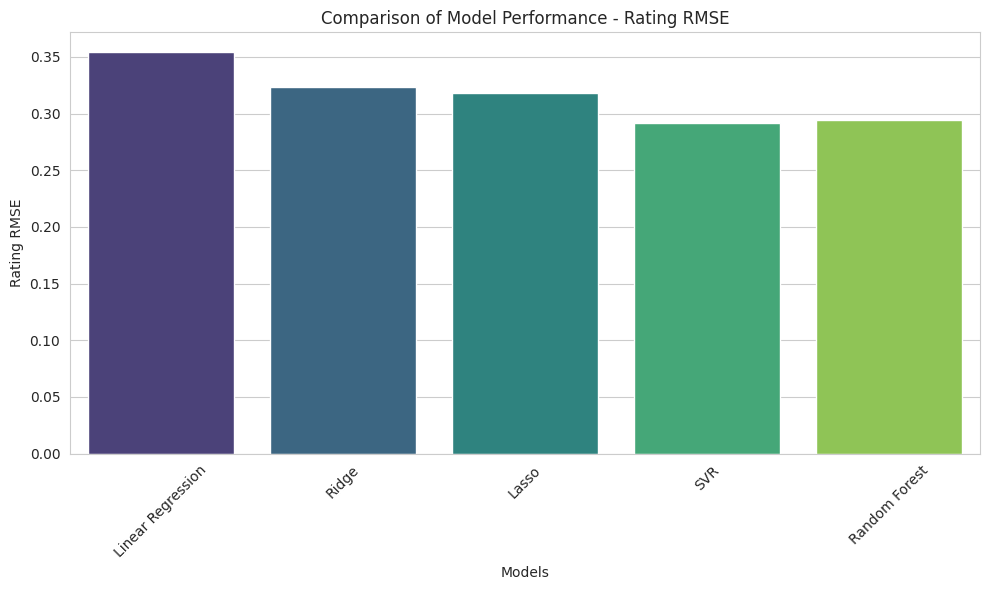

<ipython-input-8-d72dbb1f3f7b>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=box_office_rmse, palette="magma")


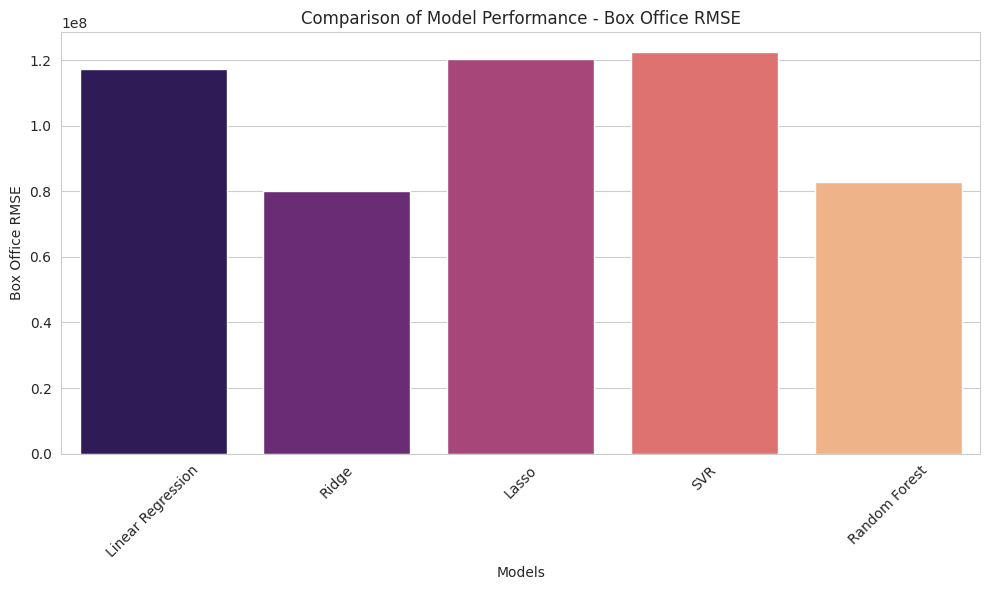

In [8]:
# Extract model names and RMSE scores
model_names = list(results.keys())
rating_rmse = [result[0] for result in results.values()]
box_office_rmse = [result[1] for result in results.values()]

# Create the bar chart for Rating RMSE
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=rating_rmse, palette="viridis")
plt.xlabel('Models')
plt.ylabel('Rating RMSE')
plt.title('Comparison of Model Performance - Rating RMSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create the bar chart for Box Office RMSE
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=box_office_rmse, palette="magma")
plt.xlabel('Models')
plt.ylabel('Box Office RMSE')
plt.title('Comparison of Model Performance - Box Office RMSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
from os import wait
def get_user_input():
  features = ['budget', 'runtime', 'genre', 'release_season',
              'lead_actor', 'director']
  actor_features = ['lead_actor_rank', 'lead_actor_total_revenue', 'lead_actor_avg_revenue']
  actor_data = data['lead_actor'].unique()


  user_data = {}

  for feature in features:
    if feature == 'genre':
      genre_options = ['Action', 'Adventure', 'Animation',
                       'Biography', 'Comedy', 'Crime', 'Drama',
                       'Family', 'Horror', 'Mystery']
      genre_dropdown = widgets.Dropdown(
          options=genre_options,
          value=genre_options[0],
          description='Genre:',
      )
      display(genre_dropdown)
      user_data[feature] = genre_dropdown.value

    elif feature == 'release_season':
      season_options = ['Spring', 'Summer', 'Fall', 'Winter'] # Replace with your actual season options
      season_dropdown = widgets.Dropdown(
          options=season_options,
          value=season_options[0],
          description='Release Season:',
      )
      display(season_dropdown)
      user_data[feature] = season_dropdown.value

    elif feature == 'lead_actor':
      actor_dropdown = widgets.Dropdown(
          options=actor_data,
          value=actor_data[0],
          description='Lead Actor:',
      )
      display(actor_dropdown)
      user_data[feature] = actor_dropdown.value
      input("Press Enter to continue...")

      for actor_feature in actor_features:
        actor_value = data[data['lead_actor'] == user_data['lead_actor']][actor_feature].values[0]
        user_data[actor_feature] = actor_value

    elif feature == 'director':
      director_options  = data['director'].unique()
      director_dropdown = widgets.Dropdown(
          options=director_options,
          value=director_options[0],
          description='Director:',
      )
      display(director_dropdown)
      user_data[feature] = director_dropdown.value
      input("Press Enter to continue...")

    else:
      value = float(input(f"Enter {feature} (numerical value): "))
      user_data[feature] = value

  return pd.DataFrame([user_data])

In [13]:
while True:
  # Get user input
  new_data = get_user_input()

  new_data.drop(columns=['lead_actor'], inplace=True)
  best_rating_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())  # Using best model for rating.
  ])

  best_box_office_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())  # Using the best model for box office.
  ])

  best_rating_model_pipeline.fit(X, y_rating)  # For rating prediction
  best_box_office_model_pipeline.fit(X, y_box_office)  # For box office prediction

  # Predict rating and box office using the best models
  predicted_rating = best_rating_model_pipeline.predict(new_data)[0]
  predicted_box_office = best_box_office_model_pipeline.predict(new_data)[0]

  # Print the predicted values
  print(f"Predicted Rating: {predicted_rating:.2f}")
  print(f"Predicted Box Office: ${predicted_box_office:,.2f}")

  another_prediction = input("Do you want to make another prediction? (y/n): ")
  if another_prediction.lower() != 'y':
    break

Enter budget (numerical value): 34000000
Enter runtime (numerical value): 96


Dropdown(description='Genre:', options=('Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'D…

Dropdown(description='Release Season:', options=('Spring', 'Summer', 'Fall', 'Winter'), value='Spring')

Dropdown(description='Lead Actor:', options=('Tim Robbins', 'Christian Bale', 'Al Pacino', 'Elijah Wood', 'Joh…

Press Enter to continue...


Dropdown(description='Director:', options=('Frank Darabont', 'Christopher Nolan', 'Francis Ford Coppola', 'Pet…

Press Enter to continue...
Predicted Rating: 8.22
Predicted Box Office: $60,643,411.32
Do you want to make another prediction? (y/n): u
